In [23]:
## import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation ,performance_metrics
from fbprophet.plot import plot_cross_validation_metric 


%matplotlib inline

In [24]:
## read the calendar data
data_calendar = pd.read_csv('C:/calendar.csv')

In [25]:
#### time series. My focous here is the calendar data 
### price for the listings that are avaialble 
price_available = data_calendar[data_calendar['available']=='t']
price_available['price_cleaned'] = price_available['price'].str.replace('$','').apply(pd.to_numeric, errors='coerce')
price_available['date'] = pd.to_datetime(price_available['date'])
price_available = price_available.drop(columns=['listing_id','available','price'], axis = 1)

## average price per day for unique listing ids
mean_price = price_available.groupby(price_available.date).mean()

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [38]:
pd.plotting.register_matplotlib_converters()

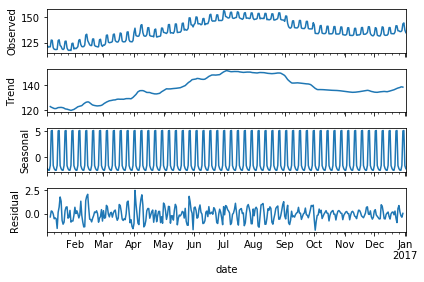

In [40]:
## plot the price rate series
# decompose the price components
# definatly there is a seasonal pattern in available listing prices 
series = mean_price
# I considered the model as additive since the changes in variance is costant over years
result = seasonal_decompose(series, model='additive') 
result.plot()
pyplot.show()

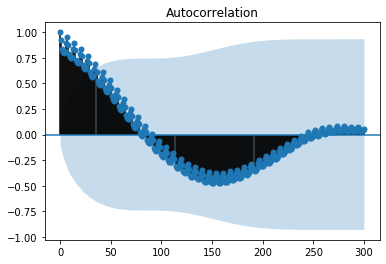

In [14]:
## Autocorrelation function (ACF) shows each lag is highly correlated to previous lags and time and 
plot_acf(series,lags =300)
pyplot.show()

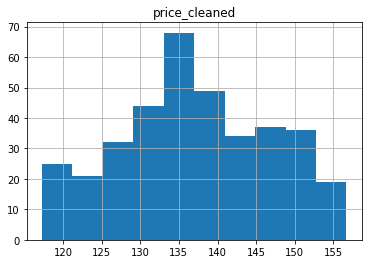

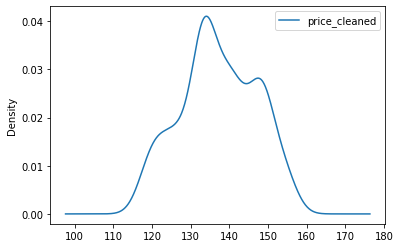

In [41]:
## as it is shown in previous notebook, it looks like average price has Gaussian distribution 
mean_price.hist()
pyplot.show()
mean_price.plot(kind='kde')
pyplot.show()

In [42]:
## As it was shown before, prices series over time is not stationary
# mean and std are different over lags so I used log transform to make it stationary 
X = mean_price.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=132.769439, mean2=141.524845
variance1=97.432256, variance2=52.861344


In [43]:
## lets use log transform and check if the series can be stationary or not
X = series.values
X = np.log(X)
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('average price:')
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%.2f, variance2=%.2f' % (var1, var2))
# It looks Stationary now

average price:
mean1=4.885883, mean2=4.951165
variance1=0.01, variance2=0.00


In [44]:
## reset the index and save it to another dataset
mean_price_new = pd.DataFrame(mean_price).reset_index()
mean_price_new.columns = ['ds','y']

In [45]:
## save a copy of y values 
mean_price_new['y_orig'] = mean_price_new['y'] 

# log-transform y
mean_price_new['y'] = np.log( mean_price_new['y'])

In [135]:
## list the federal and nonfederal holidays 2016  
# force the Prophet model to formulate if any changes in pattern or seasonality happing during this time periods
# give the lower window zero to consider the exact day, give 1 if you wanna consider a day after as well as holidays

fed = pd.DataFrame({
  'holiday': 'federal',
  'ds': pd.to_datetime(['2016-01-01', '2016-01-18', '2016-02-15',
                       '2016-05-30', '2016-07-04', '2016-09-05',
                        '2016-11-11','2016-11-24', '2016-12-26']),
  'lower_window': 0,
  'upper_window': 1,
})
non = pd.DataFrame({
  'holiday': 'non_federal',
  'ds': pd.to_datetime(['2016-05-08', '2016-1-19', '2016-11-25']),
  'lower_window': 0,
  'upper_window': 1,
})
# concatenate the federal and nonfederal holidays in one dataset 
holidays = pd.concat((fed, non))
print(holidays)

### baseline model without validating
# This fuction fit the Prophet model and forecast the future "m" months price values 
# the model input is the time series data and number of months to the future I want to forecast 
# the output is the forecasted price rates, original price rates, the holiday effects and model performance metrics like 
def forecast_data(data, forecast_period):
   
    # instantiate Prophet and call "fit" method on forecast_data
    model = Prophet(holidays=holidays , weekly_seasonality=True, yearly_seasonality=True )
    model.fit(data)
    
    ## number of future laggs
    future_data = model.make_future_dataframe(periods=forecast_period, freq = 'm')
    
    # forecast future periods
    forecast_data = model.predict(future_data)

    
    ## predicted price range with the 95% margin of error
    # select the ds: time lags , yhat: Predicted values and the predicted upper and lower bond 
    future_forecast = forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # the effect of holidays
    holiday_effect = forecast_data[(forecast_data['federal'] + forecast_data['non_federal']).abs() > 0][
        ['ds', 'federal', 'non_federal']][-10:]
    
    # to calculate the model performance metrics, I subset data to train and valid datasets.
    # for the first split, I trained the model on one month price values and tested on the next month. 
    df_cv = cross_validation(model, initial='30', period='30 days', horizon = '100 days')
    
    # return the performance metrics
    df_p = performance_metrics(df_cv)

    # plot forecast values and time series components, trend, seasonality and holiday
    fig1 = model.plot(forecast_data)
    fig2 = model.plot_components(forecast_data)
    
    # make sure we save the original forecast data
    forecast_data_orig = forecast_data 
    
    # re transform the log values to original
    forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
    forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
    forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])
    
    # return forecasted values
    return future_forecast, forecast_data_orig , holiday_effect , df_p


       holiday         ds  lower_window  upper_window
0      federal 2016-01-01             0             1
1      federal 2016-01-18             0             1
2      federal 2016-02-15             0             1
3      federal 2016-05-30             0             1
4      federal 2016-07-04             0             1
5      federal 2016-09-05             0             1
6      federal 2016-11-11             0             1
7      federal 2016-11-24             0             1
8      federal 2016-12-26             0             1
0  non_federal 2016-05-08             0             1
1  non_federal 2016-01-19             0             1
2  non_federal 2016-11-25             0             1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 9 forecasts with cutoffs between 2016-01-28 00:00:00 and 2016-09-24 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float`

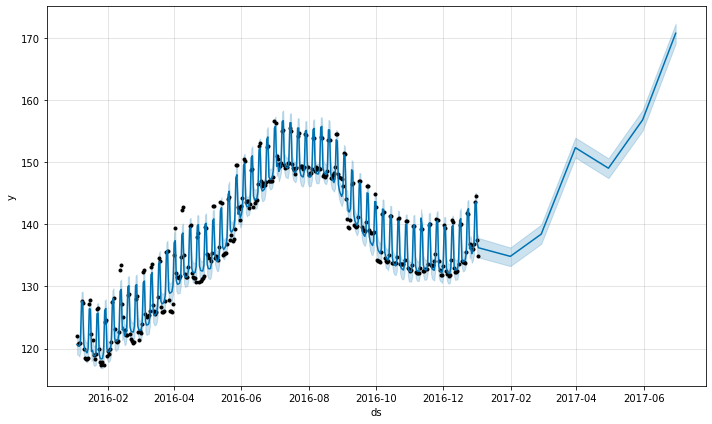

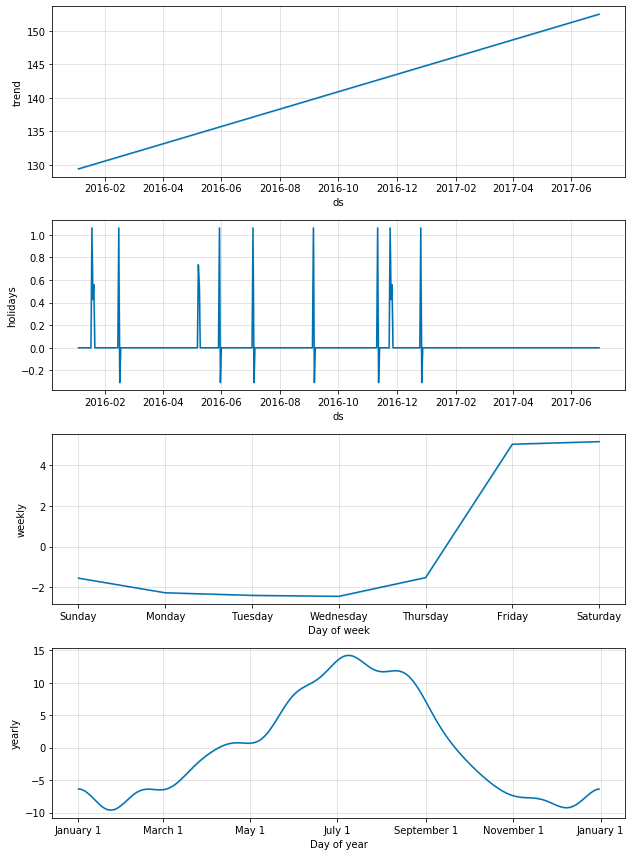

In [136]:
future_forecast, forecast_data_orig , holiday_effect, df_p = forecast_data(mean_price_new, 6)

In [94]:
## train the model with weekly and yearly seasonality with multiplicative mode
model = Prophet(holidays=holidays , weekly_seasonality=True, yearly_seasonality=True, interval_width = 0.95, seasonality_mode='multiplicative')
model.fit(mean_price_new)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [69]:
## the magnitutde of the holiday efects has been reduced compared to before
m = Prophet(holidays=holidays, holidays_prior_scale=1).fit(mean_price_new)
forecast = m.predict(future_data)
forecast[(forecast['federal'] + forecast['non_federal']).abs() > 0][
    ['ds', 'federal', 'non_federal']][-10:]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



,ds,federal,non_federal
198,2016-07-20,0.000000,0.000064
245,2016-09-05,0.013010,0.000000
246,2016-09-06,0.002878,0.000000
280,2016-10-10,0.000000,0.000563
281,2016-10-11,0.000000,0.000064
325,2016-11-24,0.013010,0.000000
326,2016-11-25,0.002878,0.000563
327,2016-11-26,0.000000,0.000064
357,2016-12-26,0.013010,0.000000
358,2016-12-27,0.002878,0.000000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-04-27 00:00:00 and 2016-09-24 00:00:00
C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

C:\Users\rahil.bagheri\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argumen

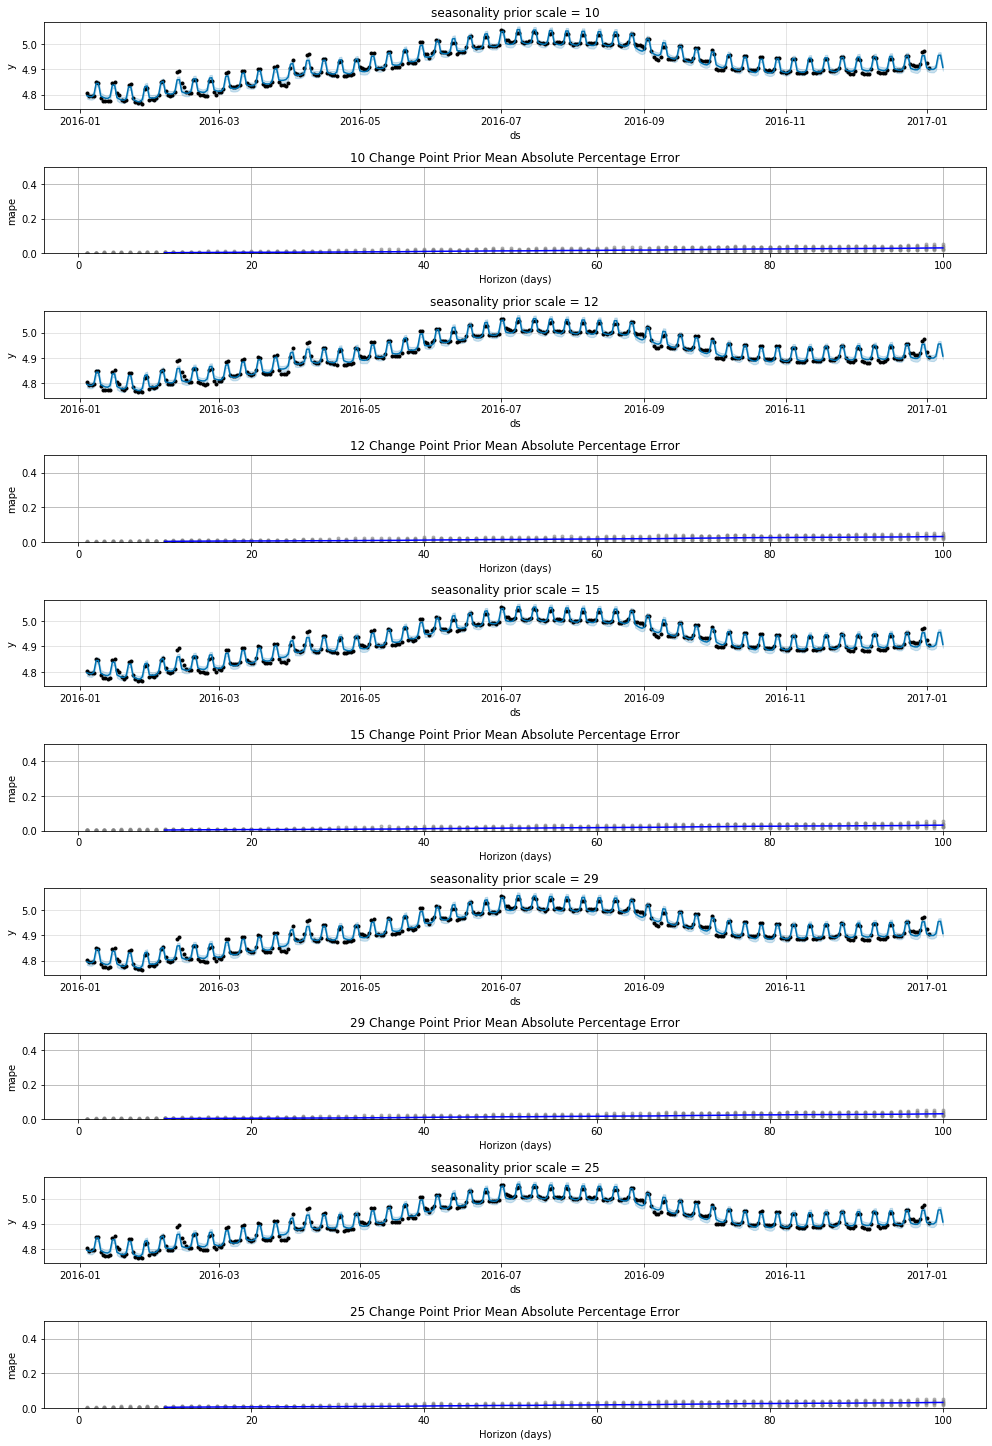

In [99]:
### grid search on selecting the best hyperparameters
# grid search on seasonality, but mean absoloute percentage error doesnt change that much 
# This grid search still can be enhanced by adding more data 
fig, ax = plt.subplots(10,1, figsize = (14, 20))
ax = ax.ravel()
j = 0
for i in [10, 12, 15, 29, 25]:
    
    m = Prophet(seasonality_prior_scale =i)
    
    #fit the prophet
    m.fit(mean_price_new)
    
    # make a future data
    future = m.make_future_dataframe(periods=6 )
    
    #forecast
    forecast = m.predict(future)
    
    # plot the forecast 
    fig = m.plot(forecast, ax = ax[j])
    ax[j].set_title('seasonality prior scale = ' + str(i))
    j += 1
    df_cv = cross_validation(m, initial='100 days', period='30 days', horizon = '100 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mape', ax = ax[j])
    ax[j].set_title(str(str(i) + ' Change Point Prior Mean Absolute Percentage Error'))
    ax[j].set_ylim(0,0.5)
    j += 1